# 📊 Group 35 Dataset

- Muhammad Bazaf Shakeel 26100146
- Sulaiman Ahmad 26100350

Welcome to the dataset exploration and processing notebook for **Group 35**.  
This document will guide you through the steps taken to load, process, and analyze the dataset.



Importing Libraries

In [ ]:
from google.colab import drive
import subprocess
import os
from dotenv import load_dotenv
from datasets import load_dataset, Features, Value, Sequence
from huggingface_hub import login
import yt_dlp
from datetime import datetime
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import random

load_dotenv('.env')

In [4]:
drive.mount('/content/drive')

# Define output directories for two different datasets
output_dir_aes = "/content/drive/MyDrive/Aes_InternVid_Clips"
output_dir_intern = "/content/drive/MyDrive/InternVid_Clips"

# Create the directories if they don't already exist
os.makedirs(output_dir_aes, exist_ok=True)
os.makedirs(output_dir_intern, exist_ok=True)

Mounted at /content/drive


Authorisation Token For Loading Datasets

In [ ]:
login(token=os.getenv('HUGGING_FACE_API'))

Loading InternVid-18M-AES Dataset

In [8]:
aes_features = Features({
    'YoutubeID': Value('string'),
    'Start_timestamp': Value('string'),
    'End_timestamp': Value('string'),
    'Caption': Value('string'),
    'Aesthetic_Score': Value('float64'),
    'CLIP_Score': Value('float64')
})

dataset_aes = load_dataset("OpenGVLab/InternVid", "InternVid-18M-AES", features=aes_features)
print("Loaded InternVid-18M-AES dataset:")
print(dataset_aes)

Loaded InternVid-18M-AES dataset:
DatasetDict({
    AES_vc2vicuna: Dataset({
        features: ['YoutubeID', 'Start_timestamp', 'End_timestamp', 'Caption', 'Aesthetic_Score', 'CLIP_Score'],
        num_rows: 17573429
    })
    AES_Ori: Dataset({
        features: ['YoutubeID', 'Start_timestamp', 'End_timestamp', 'Caption', 'Aesthetic_Score', 'CLIP_Score'],
        num_rows: 17573429
    })
})


Loading InternVid-10M Dataset

In [10]:
dataset = load_dataset("OpenGVLab/InternVid", "InternVid-10M")
print("Loaded 10M dataset:")
print(dataset)

Loaded 10M dataset:
DatasetDict({
    FLT: Dataset({
        features: ['YoutubeID', 'Start_timestamp', 'End_timestamp', 'Caption', 'Aesthetic_Score', 'UMT_Score'],
        num_rows: 10647458
    })
})


Defining the splits for each Dataset

In [14]:
aes_data = dataset_aes["AES_vc2vicuna"]
aes_data[0]

{'YoutubeID': 'ZpUYjpKg9KY',
 'Start_timestamp': '00:02:26.021',
 'End_timestamp': '00:02:26.730',
 'Caption': 'The video clip shows a large crowd of people gathered in a stadium, cheering and waving their hands in the air. The atmosphere is lively and energetic.',
 'Aesthetic_Score': 9.7421875,
 'CLIP_Score': None}

In [11]:
flt_data = dataset["FLT"]
flt_data[0]

{'YoutubeID': 'HdYoyzCSWyw',
 'Start_timestamp': '00:03:10.567',
 'End_timestamp': '00:03:11.200',
 'Caption': 'woman using a computer mouse and keyboard',
 'Aesthetic_Score': 4.58984375,
 'UMT_Score': 0.39794921875}

Downloading and Cropping the clips

In [20]:
def time_to_sec(ts):
    dt = datetime.strptime(ts, "%H:%M:%S.%f")
    return dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6

def download_and_crop(video_id, start_time, end_time, output_path):
    try:
        # Skip if already exists
        if os.path.exists(output_path):
            print(f"✅ Already exists, skipping: {output_path}")
            return True

        # Calculate clip duration before downloading
        start_sec = time_to_sec(start_time)
        end_sec = time_to_sec(end_time)
        duration = end_sec - start_sec

        # Skip if duration is outside bounds
        if duration < 3 or duration > 15:
            return False

        # Temp file path (clean workspace)
        temp_filename = f"/tmp/{video_id}.mp4"

        # yt-dlp download options
        ydl_opts = {
            'format': 'mp4',
            'outtmpl': temp_filename,
            'quiet': True,
            'noplaylist': True,
        }

        # Download video
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([f"https://www.youtube.com/watch?v={video_id}"])

        if not os.path.exists(temp_filename):
            print(f"⚠️ Video not downloaded: {video_id}")
            return False

        # Crop with ffmpeg
        ffmpeg_cmd = [
            "ffmpeg",
            "-ss", f"{start_sec:.3f}",
            "-i", temp_filename,
            "-t", f"{duration:.3f}",
            "-c:v", "libx264",
            "-c:a", "aac",
            output_path,
            "-y"
        ]
        subprocess.run(ffmpeg_cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        # Clean up
        os.remove(temp_filename)

        return os.path.exists(output_path)

    except Exception as e:
        print(f"❌ Error for {video_id}: {e}")
        return False

Saving the Clips in Google Drive

In [22]:
def save_clips(dataset_split, output_dir, N=20):
    saved_count = 0
    index = 0
    total_rows = len(dataset_split)

    print(f"🔍 Scanning {N} clips from dataset ({total_rows} total rows)...")

    while saved_count < N and index < total_rows:
        row = dataset_split[index]
        video_id = row['YoutubeID']
        start_time = row['Start_timestamp']
        end_time = row['End_timestamp']
        caption = row['Caption']

        # Safe filename formatting
        safe_start = start_time.replace(":", "-").replace(".", "-")
        safe_end = end_time.replace(":", "-").replace(".", "-")
        output_file = os.path.join(output_dir, f"{video_id}_{safe_start}_{safe_end}.mp4")

        # Skip if already exists
        if os.path.exists(output_file):
            print(f"✅ Already exists: {output_file}")
            saved_count += 1
            index += 1
            continue

        # Attempt to download & crop
        success = download_and_crop(video_id, start_time, end_time, output_file)
        if success:
            print(f"✅ Saved [{saved_count + 1}/{N}]: {output_file}")
            saved_count += 1

        index += 1

    if saved_count < N:
        print(f"⚠️ Only found {saved_count} valid clips out of {N} after scanning {index} entries.")
    else:
        print(f"🎉 Done! {N} valid clips saved to: {output_dir}")


In [23]:
save_clips(aes_data, output_dir_aes, N=20)

🔍 Scanning 20 clips from dataset (17573429 total rows)...
✅ Saved [1/20]: /content/drive/MyDrive/Aes_InternVid_Clips/KlAAQ4TzqdA_00-03-12-920_00-03-16-000.mp4
✅ Saved [2/20]: /content/drive/MyDrive/Aes_InternVid_Clips/INsDaKTFXsM_00-00-00-000_00-00-03-467.mp4
✅ Saved [3/20]: /content/drive/MyDrive/Aes_InternVid_Clips/cNKOC6I1SPI_00-08-45-200_00-08-49-120.mp4
✅ Saved [4/20]: /content/drive/MyDrive/Aes_InternVid_Clips/WTO7-CQPjdY_00-10-00-880_00-10-04-680.mp4


ERROR: [youtube] aeLEXxVTIEQ: Video unavailable


❌ Error for aeLEXxVTIEQ: ERROR: [youtube] aeLEXxVTIEQ: Video unavailable
✅ Saved [5/20]: /content/drive/MyDrive/Aes_InternVid_Clips/xreclu1ibdU_00-03-25-172_00-03-32-646.mp4
✅ Saved [6/20]: /content/drive/MyDrive/Aes_InternVid_Clips/VEfkNHTjgs8_00-04-59-090_00-05-04-930.mp4
✅ Saved [7/20]: /content/drive/MyDrive/Aes_InternVid_Clips/VtSqOaGqtLU_00-05-49-917_00-05-58-917.mp4
✅ Already exists: /content/drive/MyDrive/Aes_InternVid_Clips/SCotFoF3kKE_00-00-20-587_00-00-24-057.mp4
✅ Saved [9/20]: /content/drive/MyDrive/Aes_InternVid_Clips/NQLbCmnTe88_00-00-15-082_00-00-18-218.mp4
✅ Saved [10/20]: /content/drive/MyDrive/Aes_InternVid_Clips/NxBY_gfQbfc_00-13-23-760_00-13-27-160.mp4
✅ Saved [11/20]: /content/drive/MyDrive/Aes_InternVid_Clips/L2vDHTygLlM_00-00-51-018_00-00-58-659.mp4
✅ Saved [12/20]: /content/drive/MyDrive/Aes_InternVid_Clips/ZpUYjpKg9KY_00-00-00-000_00-00-07-090.mp4
✅ Saved [13/20]: /content/drive/MyDrive/Aes_InternVid_Clips/Q3Wrbp2Huk4_00-05-13-480_00-05-23-990.mp4
✅ Saved [14/

In [24]:
save_clips(flt_data, output_dir_intern, N=20)

🔍 Scanning 20 clips from dataset (10647458 total rows)...
✅ Saved [1/20]: /content/drive/MyDrive/InternVid_Clips/_VljYs8BhSE_00-00-07-533_00-00-11-633.mp4
✅ Saved [2/20]: /content/drive/MyDrive/InternVid_Clips/0rBo_9yyE9g_00-00-18-033_00-00-24-367.mp4
✅ Saved [3/20]: /content/drive/MyDrive/InternVid_Clips/RB1olEZyXYU_00-01-57-217_00-02-00-721.mp4
✅ Saved [4/20]: /content/drive/MyDrive/InternVid_Clips/lLN8ZIqkLiY_00-11-40-533_00-11-51-967.mp4
✅ Saved [5/20]: /content/drive/MyDrive/InternVid_Clips/oO3P-JaBvp8_00-01-25-955_00-01-31-391.mp4
✅ Saved [6/20]: /content/drive/MyDrive/InternVid_Clips/CcGB39f66RY_00-00-00-000_00-00-03-028.mp4
✅ Saved [7/20]: /content/drive/MyDrive/InternVid_Clips/DPMLACR5jd0_00-00-00-000_00-00-05-080.mp4
✅ Saved [8/20]: /content/drive/MyDrive/InternVid_Clips/aBkvV169x4k_00-06-57-584_00-07-06-693.mp4
✅ Saved [9/20]: /content/drive/MyDrive/InternVid_Clips/m0216aNTjgI_00-00-10-233_00-00-18-733.mp4
✅ Saved [10/20]: /content/drive/MyDrive/InternVid_Clips/KAyKtlI3AfM_0

[download] Got error: HTTPSConnectionPool(host='rr1---sn-a5mekn6r.googlevideo.com', port=443): Read timed out.


[download] Got error: HTTPSConnectionPool(host='rr1---sn-a5mekn6r.googlevideo.com', port=443): Read timed out.
✅ Saved [13/20]: /content/drive/MyDrive/InternVid_Clips/0XS5cYSuyC8_00-02-15-167_00-02-22-133.mp4
✅ Saved [14/20]: /content/drive/MyDrive/InternVid_Clips/l57lPxTBOts_00-04-53-668_00-04-59-466.mp4
✅ Saved [15/20]: /content/drive/MyDrive/InternVid_Clips/5bIzMeC6Djk_00-00-00-000_00-00-05-100.mp4
✅ Saved [16/20]: /content/drive/MyDrive/InternVid_Clips/2g2qPtnIy_M_00-07-02-667_00-07-06-500.mp4
✅ Saved [17/20]: /content/drive/MyDrive/InternVid_Clips/xEe8foRNh4k_00-01-48-633_00-01-55-633.mp4
✅ Saved [18/20]: /content/drive/MyDrive/InternVid_Clips/dMVYlwTVjYQ_00-03-59-160_00-04-04-440.mp4
✅ Saved [19/20]: /content/drive/MyDrive/InternVid_Clips/Tgr7TFr5Lrg_00-00-42-879_00-00-45-925.mp4
✅ Saved [20/20]: /content/drive/MyDrive/InternVid_Clips/k5kNtIJToIg_00-02-38-792_00-02-42-250.mp4
🎉 Done! 20 valid clips saved to: /content/drive/MyDrive/InternVid_Clips


Creating Train/Test Splits for each DataFrame

In [50]:
def create_clip_dataframe(dataset_split, output_dir, scan_limit=500):
    rows = []

    for i, row in enumerate(dataset_split.select(range(scan_limit))):
        video_id = row["YoutubeID"]
        start = row["Start_timestamp"].replace(":", "-").replace(".", "-")
        end = row["End_timestamp"].replace(":", "-").replace(".", "-")
        filename = f"{video_id}_{start}_{end}.mp4"
        filepath = os.path.join(output_dir, filename)

        if os.path.exists(filepath):
            rows.append({
                "VideoID": video_id,
                "Caption": row["Caption"]
            })

    return pd.DataFrame(rows)

aes_df = create_clip_dataframe(aes_data, output_dir_aes, scan_limit=500)
flt_df = create_clip_dataframe(flt_data, output_dir_intern, scan_limit=500)

In [51]:
print("AES DataFrame:")
aes_df.head()

AES DataFrame:


,VideoID,Caption
0,KlAAQ4TzqdA,The video clip shows a group of men dressed in...
1,INsDaKTFXsM,The video clip shows a painting on the ceiling...
2,cNKOC6I1SPI,The video clip shows a man wearing a white sui...
3,WTO7-CQPjdY,The video clip shows a man wearing an orange s...
4,xreclu1ibdU,The video clip shows a woman standing in front...


In [52]:
print("FLT DataFrame:")
flt_df.head()

FLT DataFrame:


,VideoID,Caption
0,_VljYs8BhSE,diy gift wrap box video - how to make the diy ...
1,0rBo_9yyE9g,the bridge of a river being viewed from a cable
2,RB1olEZyXYU,south korea introduces water bombs to contain ...
3,lLN8ZIqkLiY,a chinese advertisement with a man and his whi...
4,oO3P-JaBvp8,puzzle dust circus - poi classes & performance


In [54]:
aes_train_df, aes_test_df = train_test_split(aes_df, test_size=0.2, random_state=42)
flt_train_df, flt_test_df = train_test_split(flt_df, test_size=0.2, random_state=42)

In [55]:
aes_train_df['Caption'].iloc[0]

"The video clip shows a man dressed as a bunny rabbit and a woman dressed as a bunny rabbit dancing together on a brick walkway. They appear to be having fun and enjoying each other's company."

In [56]:
flt_train_df['Caption'].iloc[0]

'a woman is sitting on a street corner near a bus stop'

In [ ]:
def display_video_frames(video_path, caption, n_frames=3):
    """
    Displays n consecutive frames from a video and sets the plot title to the caption.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    frames = []
    for i in range(n_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  

    cap.release()

    if frames:
        fig, axes = plt.subplots(1, len(frames), figsize=(15, 5)) 
        for i, frame in enumerate(frames):
            axes[i].imshow(frame)
            axes[i].axis('off')
            axes[i].set_title(f"Frame {i}")

        plt.suptitle(f"Caption: {caption}")  
        plt.show()
        plt.figure()
        print("\n")
    else:
        print(f"No frames found in {video_path}")

# Displaying Frames from AES **Train** Dataframe






DISPLAYING THE FIRST 3 FRAMES OF 3 RANDOM VIDEOS FROM AES TRAIN DATASET



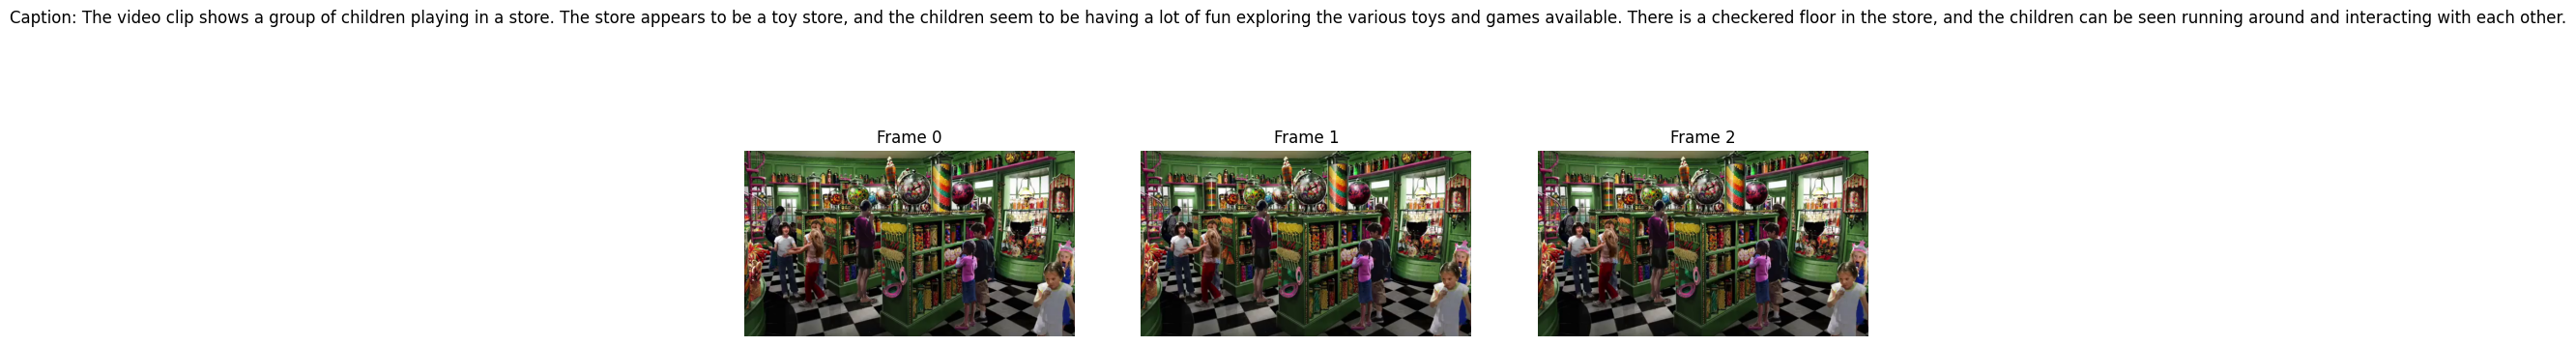

<Figure size 640x480 with 0 Axes>

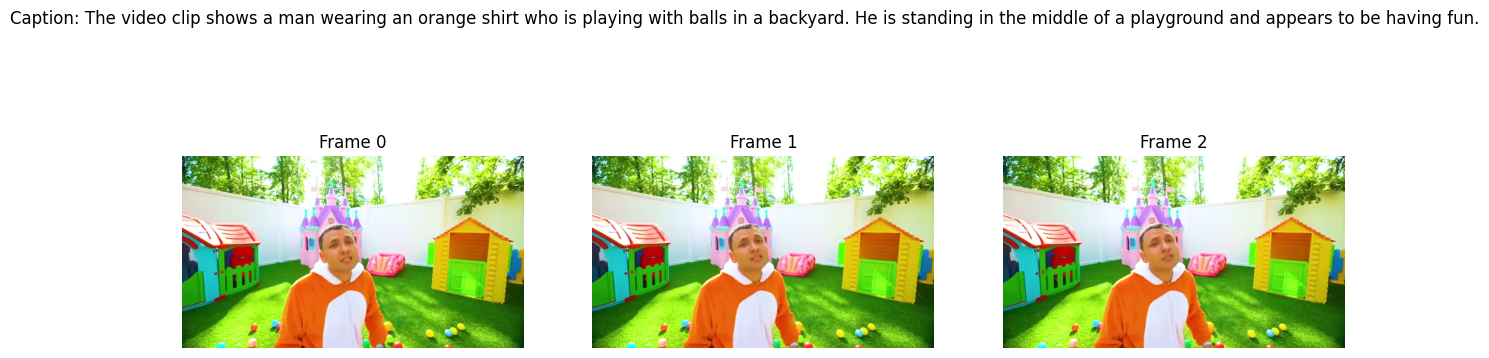

<Figure size 640x480 with 0 Axes>

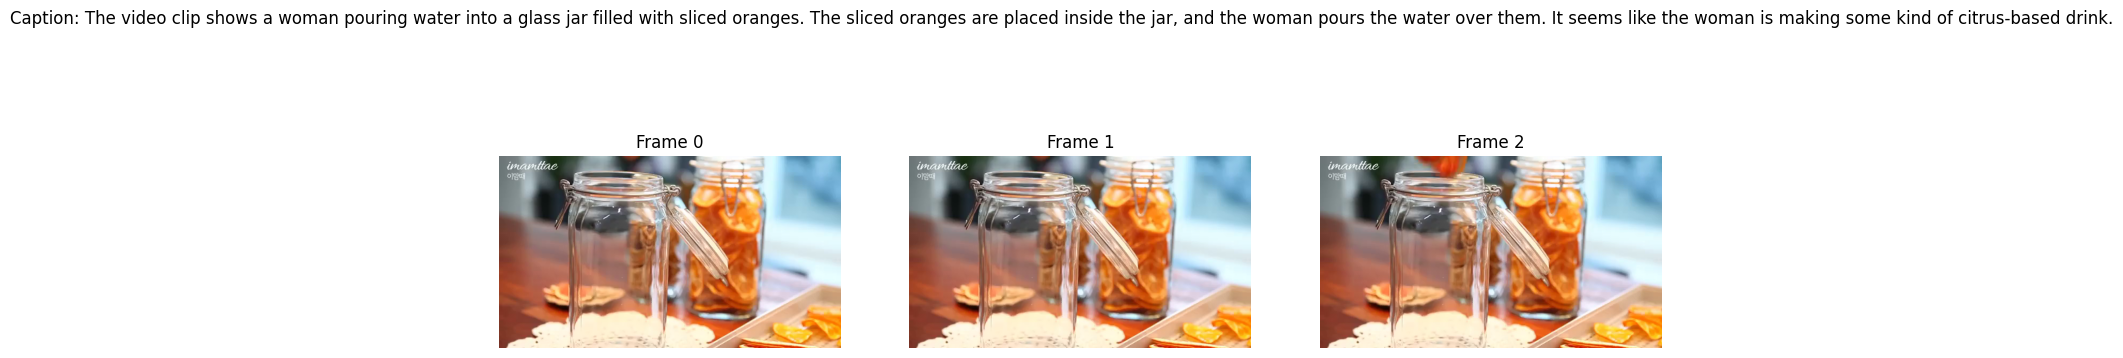

<Figure size 640x480 with 0 Axes>

In [ ]:
num_random_videos = 3  
n_frames_to_display = 3  

# --- Displaying frames from AES Train Dataset ---
print(f"\nDISPLAYING THE FIRST {n_frames_to_display} FRAMES OF {num_random_videos} RANDOM VIDEOS FROM AES TRAIN DATASET\n")

if not aes_train_df.empty:
    random_indices_aes = random.sample(aes_train_df.index.tolist(), min(num_random_videos, len(aes_train_df)))

    for index in random_indices_aes:
        row = aes_train_df.loc[index]
        video_id = row['VideoID']
        start_time_safe = row['Caption'].replace(":", "-").replace(".", "-")
        end_time_safe = row['Caption'].replace(":", "-").replace(".", "-")   
        caption = row['Caption']

        found_file = None
        for filename in os.listdir(output_dir_aes):
            if filename.startswith(video_id + "_") and filename.endswith(".mp4"):
                found_file = os.path.join(output_dir_aes, filename)

                parts = filename.split("_")
                if len(parts) > 2:
                    start_time_safe = parts[1]
                    end_time_safe = parts[2].replace(".mp4", "")
                break

        if found_file:
            display_video_frames(found_file, caption, n_frames=n_frames_to_display)
        else:
            print(f"Video file not found for VideoID: {video_id} in {output_dir_aes}")
else:
    print("AES Train DataFrame is empty.")

# Displaying Frames from AES **Test** Dataframe


DISPLAYING THE FIRST 3 FRAMES OF 3 RANDOM VIDEOS FROM AES TEST DATASET



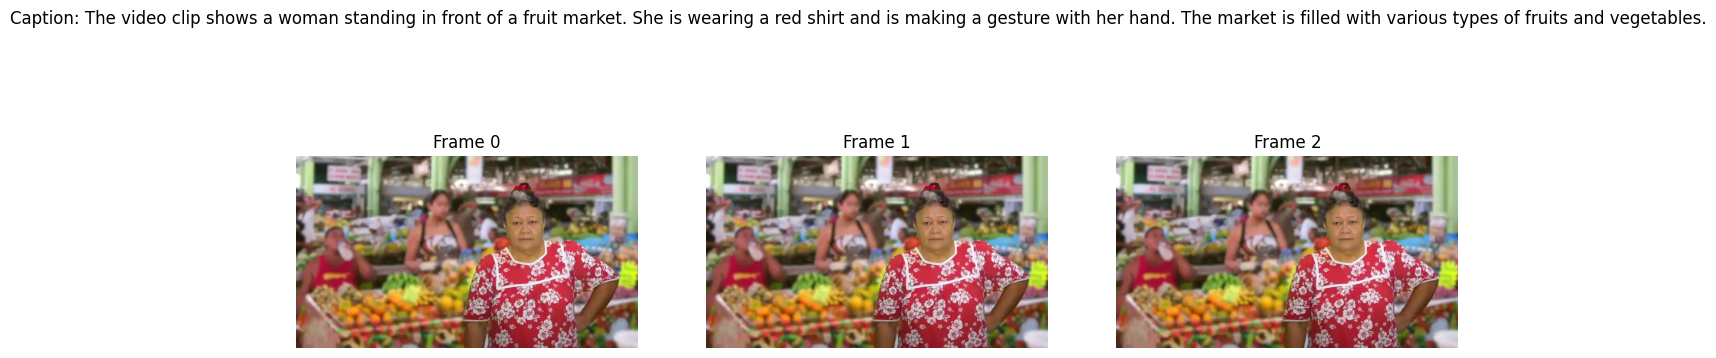

<Figure size 640x480 with 0 Axes>

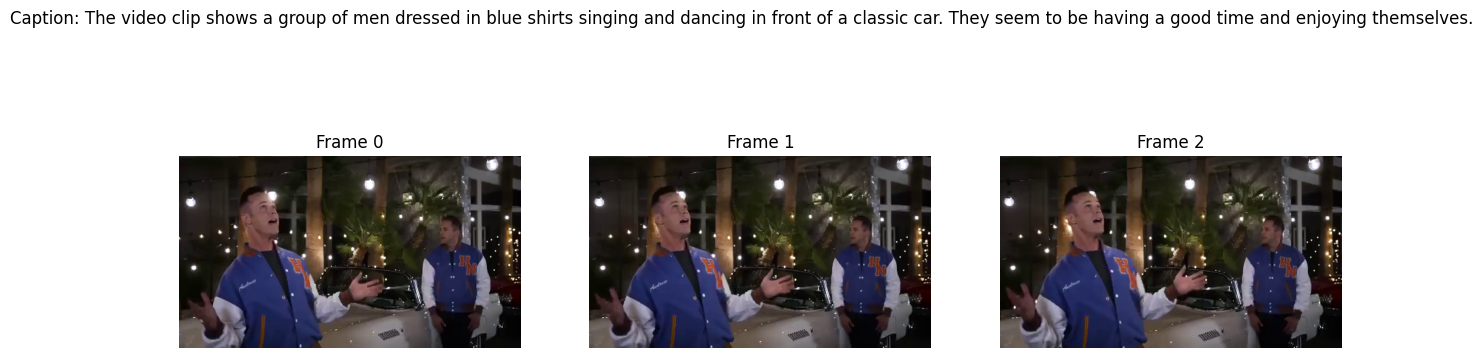

<Figure size 640x480 with 0 Axes>

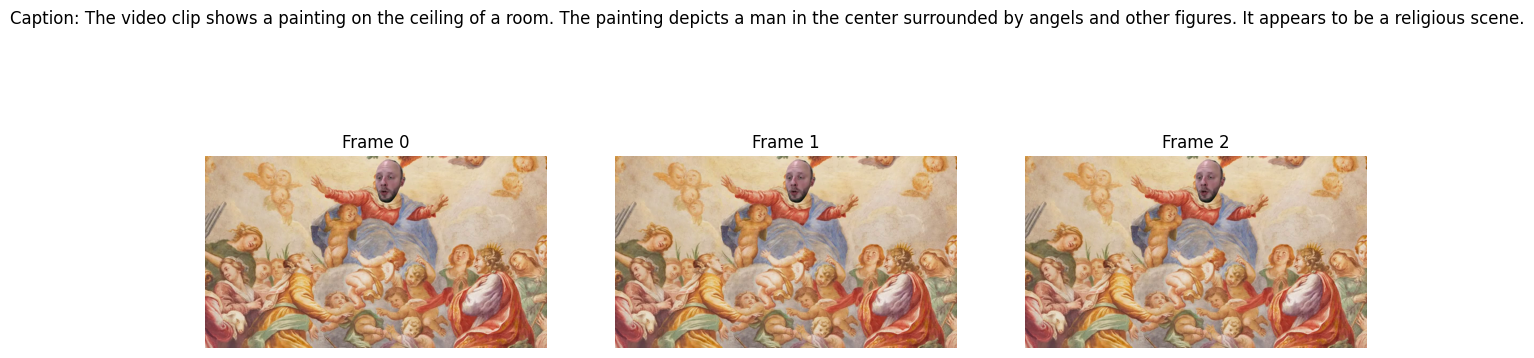

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Displaying frames from AES Test Dataset ---
print(f"\nDISPLAYING THE FIRST {n_frames_to_display} FRAMES OF {num_random_videos} RANDOM VIDEOS FROM AES TEST DATASET\n")

if not aes_test_df.empty:
    random_indices_aes_test = random.sample(aes_test_df.index.tolist(), min(num_random_videos, len(aes_test_df)))

    for index in random_indices_aes_test:
        row = aes_test_df.loc[index]
        video_id = row['VideoID']
        start_time_safe = row['Caption'].replace(":", "-").replace(".", "-") 
        end_time_safe = row['Caption'].replace(":", "-").replace(".", "-")   
        caption = row['Caption']

        found_file = None
        for filename in os.listdir(output_dir_aes):
            if filename.startswith(video_id + "_") and filename.endswith(".mp4"):
                found_file = os.path.join(output_dir_aes, filename)
                parts = filename.split("_")
                if len(parts) > 2:
                    start_time_safe = parts[1]
                    end_time_safe = parts[2].replace(".mp4", "")
                break

        if found_file:
            display_video_frames(found_file, caption, n_frames=n_frames_to_display)
        else:
            print(f"Video file not found for VideoID: {video_id} in {output_dir_aes}")
else:
    print("AES Test DataFrame is empty.")

# Displaying Frames from FLT **Train** Dataframe


DISPLAYING THE FIRST 3 FRAMES OF 3 RANDOM VIDEOS FROM FLT TRAIN DATASET



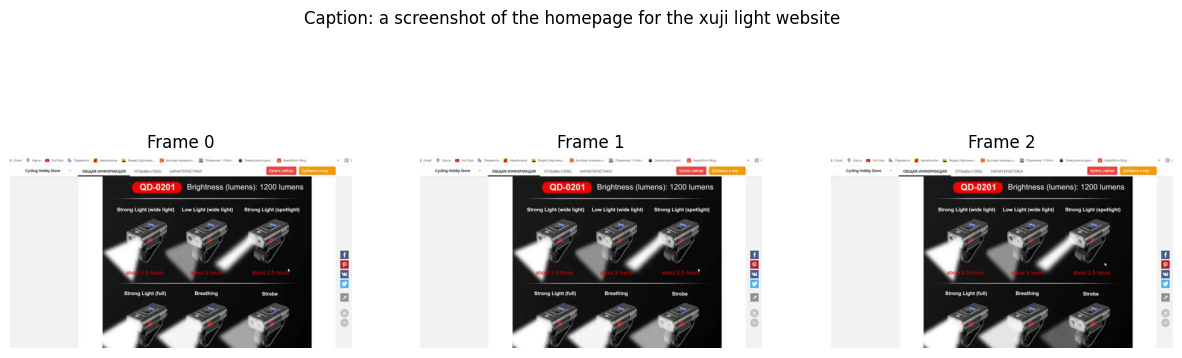

<Figure size 640x480 with 0 Axes>

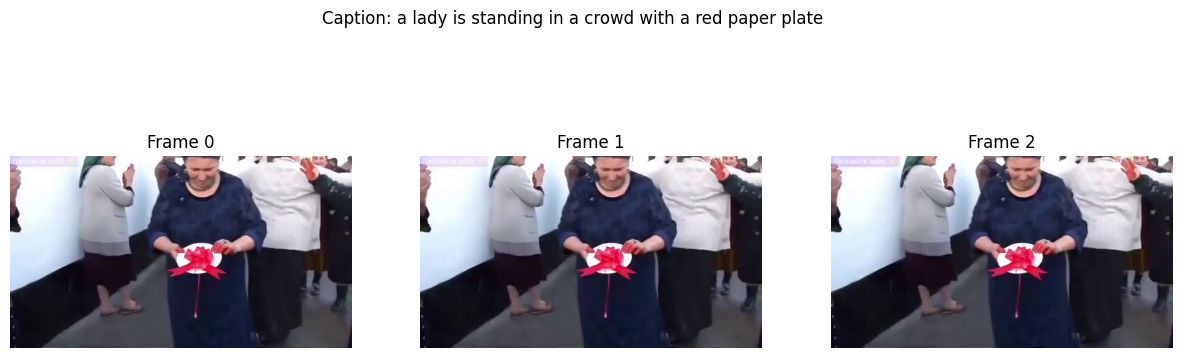

<Figure size 640x480 with 0 Axes>

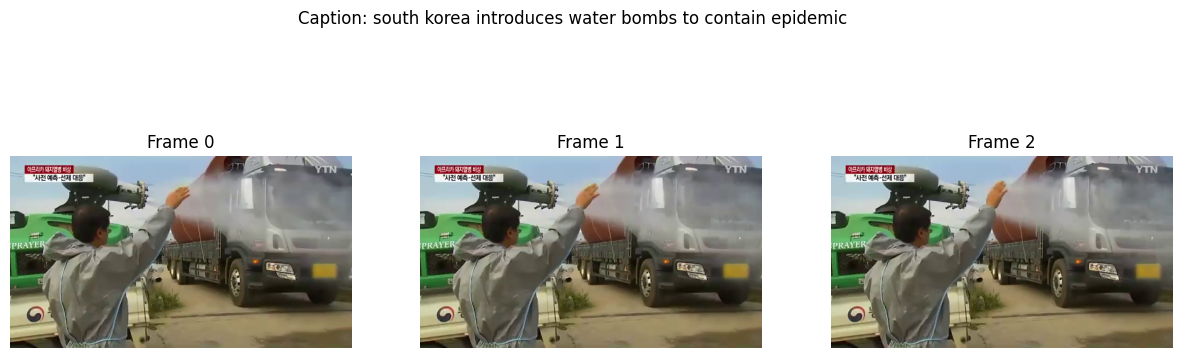

<Figure size 640x480 with 0 Axes>

In [64]:
# --- Displaying frames from FLT Train Dataset ---
print(f"\nDISPLAYING THE FIRST {n_frames_to_display} FRAMES OF {num_random_videos} RANDOM VIDEOS FROM FLT TRAIN DATASET\n")

if not flt_train_df.empty:
    random_indices_flt = random.sample(flt_train_df.index.tolist(), min(num_random_videos, len(flt_train_df)))

    for index in random_indices_flt:
        row = flt_train_df.loc[index]
        video_id = row['VideoID']
        start_time_safe = row['Caption'].replace(":", "-").replace(".", "-")
        end_time_safe = row['Caption'].replace(":", "-").replace(".", "-")
        caption = row['Caption']

        found_file = None
        for filename in os.listdir(output_dir_intern):
            if filename.startswith(video_id + "_") and filename.endswith(".mp4"):
                found_file = os.path.join(output_dir_intern, filename)
                parts = filename.split("_")
                if len(parts) > 2:
                    start_time_safe = parts[1]
                    end_time_safe = parts[2].replace(".mp4", "")
                break

        if found_file:
            display_video_frames(found_file, caption, n_frames=n_frames_to_display)
        else:
            print(f"Video file not found for VideoID: {video_id} in {output_dir_intern}")
else:
    print("FLT Train DataFrame is empty.")

# Displaying Frames from FLT **Test** Dataframe


DISPLAYING THE FIRST 3 FRAMES OF 3 RANDOM VIDEOS FROM FLT TEST DATASET



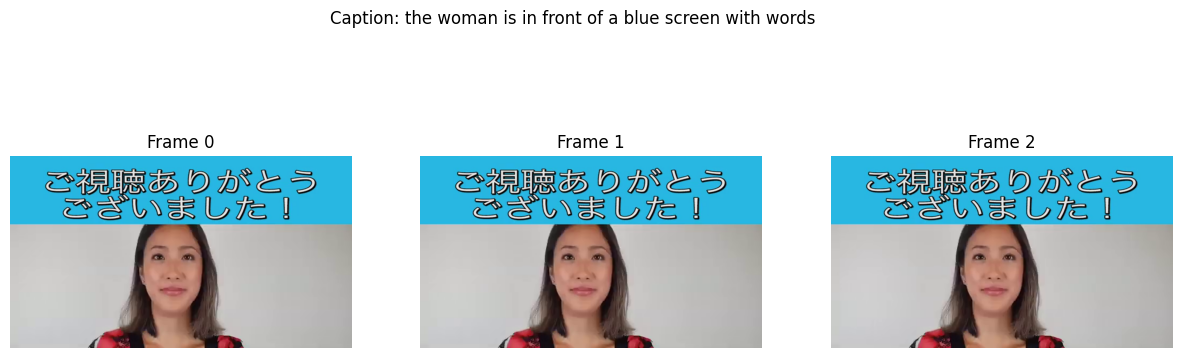

<Figure size 640x480 with 0 Axes>

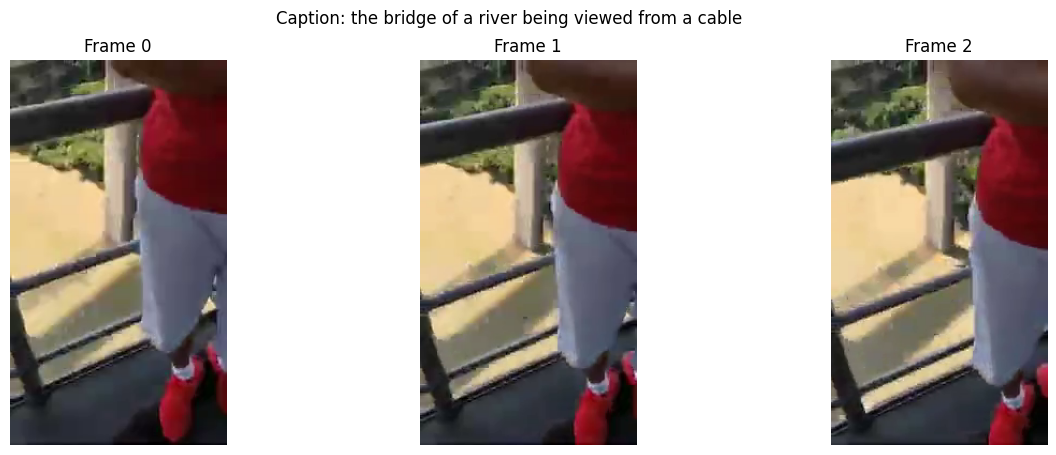

<Figure size 640x480 with 0 Axes>

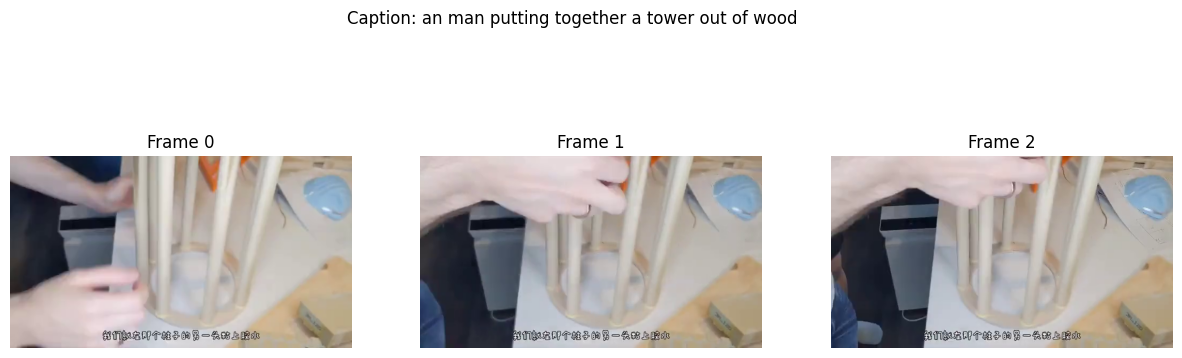

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Displaying frames from FLT Test Dataset ---
print(f"\nDISPLAYING THE FIRST {n_frames_to_display} FRAMES OF {num_random_videos} RANDOM VIDEOS FROM FLT TEST DATASET\n")

if not flt_test_df.empty:
    random_indices_flt_test = random.sample(flt_test_df.index.tolist(), min(num_random_videos, len(flt_test_df)))

    for index in random_indices_flt_test:
        row = flt_test_df.loc[index]
        video_id = row['VideoID']
        start_time_safe = row['Caption'].replace(":", "-").replace(".", "-") 
        end_time_safe = row['Caption'].replace(":", "-").replace(".", "-")   
        caption = row['Caption']

        found_file = None
        for filename in os.listdir(output_dir_intern):
            if filename.startswith(video_id + "_") and filename.endswith(".mp4"):
                found_file = os.path.join(output_dir_intern, filename)
                parts = filename.split("_")
                if len(parts) > 2:
                    start_time_safe = parts[1]
                    end_time_safe = parts[2].replace(".mp4", "")
                break

        if found_file:
            display_video_frames(found_file, caption, n_frames=n_frames_to_display)
        else:
            print(f"Video file not found for VideoID: {video_id} in {output_dir_intern}")
else:
    print("FLT Test DataFrame is empty.")

# Dataset Selection: AES Version of InternVid
For this project, we chose the AES version of the InternVid dataset due to:

Shorter Videos: The AES dataset contains shorter video clips compared to other versions. This significantly reduces the compile time, making the preprocessing and training phases more efficient.

More Detailed Captions: The captions in the AES dataset are more detailed and structured, which makes them better suited for our target (Y) data. These detailed captions allow for more precise training, providing a richer source of information for modeling.

InternVid_10m can be used for comparisons if needed later on.